# Baseline

**Goal:** Calculate the MDR + min $D_{hh}$ accuracy on the *training* set so that I can underrstand *how* and *where* my models are limited.

I.e, this can help me understand if I'm 
1. Choosing the wrong jets
2. Choosing the wrong pairing

I can also look case-by-case at these events to compare the decisions between two algorithms!!

In [2]:
import pandas as pd
import numpy as np
import torch
import json

import matplotlib.pyplot as plt

from preprocess import getNumPairs, scale, transformData, prepareData, jetVars, applyCuts
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy
from GNNPlots import trainingMetrics

from preprocess import getHCs, applyCuts, getHelicityAngles
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path.append('../code')
from analysis import normalizeWeight

# The lines below let you edit codes in modules and update the function definitions
# in your notebook automatically without having to load them in again.
%load_ext autoreload
%autoreload 2

In [3]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

**Note:** When there's no ML - I think it's ok to use *all* of the events to make a decision - maybe?

In [4]:
subDir = f'{physicsSample}_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'

df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')

In [5]:
for c in df.columns:
    print(c)

eventNumber
nresolvedJets
resolved_nBTags
mcEventWeight
weight_pileup
rand_run_nr
j0_pt
j0_eta
j0_phi
j0_E
j0_Db
j0_sf
j1_pt
j1_eta
j1_phi
j1_E
j1_Db
j1_sf
j2_pt
j2_eta
j2_phi
j2_E
j2_Db
j2_sf
j3_pt
j3_eta
j3_phi
j3_E
j3_Db
j3_sf
j4_pt
j4_eta
j4_phi
j4_E
j4_Db
j4_sf
njets
HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25
HLT_j100_2j55_bmv2c2060_split
HLT_j225_bmv2c2060_split
trigger
mc_sf
ntag
h0_pt
h0_eta
h0_phi
h0_barcode
h1_pt
h1_eta
h1_phi
h1_barcode
b0_pt
b0_eta
b0_phi
b0_parent_barcode
b1_pt
b1_eta
b1_phi
b1_parent_barcode
b2_pt
b2_eta
b2_phi
b2_parent_barcode
b3_pt
b3_eta
b3_phi
b3_parent_barcode
truth_mhh
truth_pthh
b0_jidx
b0_drMatch
b1_jidx
b1_drMatch
b2_jidx
b2_drMatch
b3_jidx
b3_drMatch
j0_bidx
j1_bidx
j2_bidx
j3_bidx
j4_bidx
j0_drMatch
j1_drMatch
j2_drMatch
j3_drMatch
j4_drMatch
correctPair
sameParent
unique
dRmatch
goodJets
ml_j0_pt
ml_j1_pt
ml_j2_pt
ml_j3_pt
ml_j4_pt
ml_j0_eta
ml_j1_eta
ml_j2_eta
ml_j3_eta
ml_j4_eta
ml_j0_phi
ml_j1_phi
ml_j2_phi
ml_j3_phi
ml_j4_phi
ml_j0_E
ml_

**Step 1:** Compute how often we select the correct four jets, and maybe if it changes depending if I sort by $D_b$ quantile or $b$-tagging decision?

In [387]:
mask = (df.ntag >= 4) & df.trigger
dfi = df.loc[mask,[f'j{i}_{v}' for i in range(nSelectedJets) for v in jetVars]+[f'b{i}_{v}' for i in range(4) for v in ['jidx','drMatch']] +['njets','correctPair','mc_sf','dRmatch']]

In [175]:
dfi

j0_pt    j0_eta    j0_phi         j0_E  j0_Db       j1_pt  \
entry                                                                    
2       141.734589 -1.114459  0.415969   240.037628      5  119.388428   
13      311.470001 -1.352279 -2.415778   642.685059      1  295.764099   
23      402.236237  0.372861 -2.307149   430.686401      4  251.344147   
27      120.562096 -1.603234  0.880607   312.042725      3   67.502884   
29      106.598648  0.829086 -3.006797   145.824203      4   99.164276   
...            ...       ...       ...          ...    ...         ...   
777116   77.872765 -1.994352  1.952961   291.491577      5   55.121044   
777126  326.066956 -1.914548  1.052918  1130.196411      1  281.725647   
777139  169.626587  1.005812  2.972709   263.260620      5  148.341202   
777144  188.015274  0.306945 -2.609013   197.268982      5  144.499008   
777145  106.015533  0.617813 -0.337005   127.151184      4   92.773453   

          j1_eta    j1_phi        j1_E  j1_Db  ...    j3_eta    j3_phi  \
entry                                          ...                       
2      -0.215671 -2.185306  122.810539      5  ...  0.401709  2.350585   
13     -1.411579  2.243848  642.890015      5  ...  0.514193 -0.218663   
23      1.809259  0.634112  788.273376      5  ...  1.253225  1.424512   
27      0.820917 -1.277421   91.913567      5  ...  1.379262  3.100854   
29      0.804723 -0.393616  133.502625      5  ...  1.581177 -2.946602   
...          ...       ...         ...    ...  ...       ...       ...   
777116 -1.344578  0.397494  113.081573      5  ... -1.507983 -2.174055   
777126  1.491297 -2.951824  658.180237      4  ...  1.081529 -2.263388   
777139 -0.277653  0.159235  154.605118      5  ...  2.192173 -2.912004   
777144  0.881634  0.610938  205.051804      5  ... -0.407863  2.281693   
777145  1.687833  3.058738  259.550873      5  ...  0.610257 -2.850439   

              j3_E  j3_Db       j4_pt    j4_eta    j4_phi        j4_E  j4_Db  \
entry                                                                          
2       105.142365      1   92.037949 -0.829471  1.440184  125.927032      5   
13      167.269226      5  112.744110 -1.576377  2.797049  284.424744      3   
23      153.062195      1   96.292961  2.089880  1.077654  395.271149      5   
27      156.518021      4    0.000000  0.000000  0.000000    0.000000      0   
29      207.358719      5    0.000000  0.000000  0.000000    0.000000      0   
...            ...    ...         ...       ...       ...         ...    ...   
777116  118.843132      4    0.000000  0.000000  0.000000    0.000000      0   
777126  150.753860      5   86.267853  1.349341 -1.022725  177.962997      5   
777139  253.533646      5    0.000000  0.000000  0.000000    0.000000      0   
777144   58.899216      5    0.000000  0.000000  0.000000    0.000000      0   
777145   66.723213      3    0.000000  0.000000  0.000000    0.000000      0   

        njets  
entry          
2           5  
13          5  
23          5  
27          4  
29          4  
...       ...  
777116      4  
777126      5  
777139      4  
777144      4  
777145      4  

[86969 rows x 26 columns]

In [139]:
df.loc[df.njets==5,'correctPair'].max()

14

**Resort the jets by $D_b$ quantile**

In [336]:
X = dfi[[f'j{i}_{v}' for i in range(nSelectedJets) for v in jetVars]].values.reshape(-1,nSelectedJets,len(jetVars))

In [337]:
idx = np.argsort(X[:,:,-1],axis=1)#[:,::-1]

**Get 4-vectors**

In [338]:
xi = np.arange(len(dfi.index)).reshape(-1,1)

In [351]:
'''
Jets are first sorted by b-tag quantile, and *then* by pT, so the first jet
in the sorted list will always be the one we drop
'''
pts  = X[:,:,0][xi, idx[:,1:]]
etas = X[:,:,1][xi, idx[:,1:]]
phis = X[:,:,2][xi, idx[:,1:]]
Es   = X[:,:,3][xi, idx[:,1:]]

j0 = TLorentzVectorArray.from_ptetaphie(pts[:,0], etas[:,0], phis[:,0], Es[:,0])
j1 = TLorentzVectorArray.from_ptetaphie(pts[:,1], etas[:,1], phis[:,1], Es[:,1])
j2 = TLorentzVectorArray.from_ptetaphie(pts[:,2], etas[:,2], phis[:,2], Es[:,2])
j3 = TLorentzVectorArray.from_ptetaphie(pts[:,3], etas[:,3], phis[:,3], Es[:,3])

In [357]:
idx[:5,1:]

array([[0, 1, 2, 4],
       [4, 1, 2, 3],
       [0, 2, 1, 4],
       [0, 2, 3, 1],
       [0, 1, 2, 3]])

In [353]:
dfi[[f'b{i}_jidx' for i in range(4)]].head()

b0_jidx  b1_jidx  b2_jidx  b3_jidx
entry                                    
2            0        2        1        4
13           1        2        3        4
23           0        1        4        2
27           0        3        2        1
29           0        1        2        3

In [388]:
out = np.concatenate((idx[:,1:], dfi[[f'b{i}_jidx' for i in range(4)]].values),axis=1)

dfi['correctJets'] = [(len(np.unique(oi))==4) & np.max(np.unique(oi,return_counts=True)[1]==2) for oi in out]

In [359]:
np.sum(dfi.loc[dfi.correctJets,'mc_sf']) / np.sum(dfi.mc_sf)

0.9417424816449738

In [390]:
np.sum(dfi.loc[dfi.correctJets & dfi.dRmatch,'mc_sf']) / np.sum(dfi.loc[dfi.dRmatch,'mc_sf'])

0.9592799319437383

In [393]:
np.max(dfi.loc[~dfi.dRmatch,'correctPair'])

-1

Ok - so if I didn't pass the $R^{match}$ criterion, I'll never have a correctPair listed... **good**!!

In [36]:
from preprocess import MDR_cut

In [161]:
jetToHCIdx[5][frozenset([frozenset([4,2]),frozenset([1,0])])]

3

In [402]:
jetToHCIdx = {njets: {frozenset([hi1,hi2]): i*3+j for i,(i0,i1,i2,i3) in enumerate(combinations(range(njets),4)) \
                                                  for j, (hi1, hi2) in enumerate(zip([frozenset([i0,i1]),frozenset([i0,i2]),frozenset([i0,i3])],
                                                                                     [frozenset([i2,i3]),frozenset([i1,i3]),frozenset([i1,i2])])) } \
              for njets in range(4,nSelectedJets+1)}

In [407]:
dfi[f'pair0_yi'] = [ jetToHCIdx[nj][frozenset([frozenset([i0,i1]),frozenset([i2,i3])])]  for nj, (i0,i1,i2,i3) in zip(dfi.njets,idx[:,1:])]
dfi[f'pair1_yi'] = [ jetToHCIdx[nj][frozenset([frozenset([i0,i2]),frozenset([i1,i3])])]  for nj, (i0,i1,i2,i3) in zip(dfi.njets,idx[:,1:])]
dfi[f'pair2_yi'] = [ jetToHCIdx[nj][frozenset([frozenset([i0,i3]),frozenset([i1,i2])])]  for nj, (i0,i1,i2,i3) in zip(dfi.njets,idx[:,1:])]

In [408]:
dfi['m4j'] = (j0+j1+j2+j3).mass

for i, (j11,j12,j21,j22) in enumerate(zip([j0,j0,j0], [j1,j2,j3], [j2,j1,j1], [j3,j3,j2])):
    
    print('pair',i)
    dR1 = j11.delta_r(j12)
    dR2 = j21.delta_r(j22)
    
    pT_order = j11.pt + j12.pt > j21.pt+j22.pt 
    
    dfi[f'pair{i}_dRlead'] = np.where( pT_order, dR1, dR2)
    dfi[f'pair{i}_dRsubl'] = np.where(~pT_order, dR1, dR2)
     
    # MDR validity test
    dfi[f'pair{i}_valid'] = MDR_cut(*dfi[[f'pair{i}_dRlead',f'pair{i}_dRsubl','m4j']].values.T )
        
    dfi[f'pair{i}_m1'] = np.where( pT_order, (j11+j12).mass, (j21+j22).mass)
    dfi[f'pair{i}_m2'] = np.where(~pT_order, (j11+j12).mass, (j21+j22).mass)    
    
    s = 120 / 110
    dfi[f'pair{i}_Dhh'] =  np.abs(dfi[f'pair{i}_m1'] - s * dfi[f'pair{i}_m2']) / np.sqrt(1 + s**2) 
        

pair 0
pair 1
pair 2


In [409]:
dfi['baselinePair'] = -1

pair_mask = dfi[[f'pair{i}_valid' for i in range(3)]]#.values
Dhhs = dfi[[f'pair{i}_Dhh' for i in range(3)]].values

pair_indices = dfi[[f'pair{i}_yi' for i in range(3)]].values

dfi['nValidPairs'] = np.sum(pair_mask ,axis=1)

for nvp in [1,2,3]:
    
    m = dfi.nValidPairs==nvp
    
    i_dhh = np.argmin(Dhhs[m][pair_mask[m]].reshape(-1,nvp), axis=1)
    
    dfi.loc[m,'baselinePair'] = pair_indices[m][pair_mask[m]].reshape(-1,nvp)[np.arange(np.sum(m)),i_dhh]
    

In [316]:
pair_indices[m][pair_mask[m]].shape

(1473,)

In [371]:
fourbText = "$\mathbf{ATLAS}$ Simulation Internal\n"
fourbText += f"SM NR mc16a MAR 2020 MNT, 2016 triggers\n"
fourbText += "4b DL1r 77% WP, MDR+$\min(D_{hh})$"

In [381]:
subDir

'SMNR_mc16a_PFlow-MAR2020-5jets'

In [386]:
c = 'darkturquoise'

ni,e,_ = plt.hist(dfi.nValidPairs,3,(0.5,3.5),histtype='step',color=c,
                  density=True,linewidth=2,weights=dfi.mc_sf)

plt.xticks(range(1,4))
plt.xlabel('# valid pairings',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)

ax = plt.gca()
plt.text(0,1,fourbText,ha='left',va='bottom',transform=ax.transAxes)

for i,ti in zip(range(1,4),ni):
    print(i)
    plt.text(i,ti+.01,f'{ti*100:.1f} %',ha='center',va='bottom',color=c)

plt.ylim(0,1)

plt.savefig(f'figures/{subDir}/nValidPairs_baseline.pdf')
plt.show()

1
2
3


In [361]:
ni

array([0.83453803, 0.14568919, 0.01977278])

In [319]:
dfi[[f'pair{i}_yi' for i in range(3)]+['nValidPairs','correctPair','baselinePair']].head()

pair0_yi  pair1_yi  pair2_yi  nValidPairs  correctPair  baselinePair
entry                                                                      
2             3         4         5            1            5             5
13           14        13        12            1           14            14
23            4         3         5            1            4             4
27            1         2         0            0            1            -1
29            0         1         2            1           -1             2

In [348]:
ni,e,_ = plt.hist(dfi.baselinePair,16,(-1.5,14.5),histtype='step',density=True,linewidth=1.5,weights=dfi.mc_sf)

Ok - so I'm really just trying to figure out *what* piece of this pipeline got *fucked up* - so I'm going to try looking at some event displays to gain intuition here!!

In [258]:
from eventDisplays import truthDisplay

In [322]:
mask = (df.ntag>=4) & (df.trigger)

cols = ['mcEventWeight','truth_mhh','trigger']
cols += [f'h{i}_{v}' for i in range(2) for v in ['pt','eta','phi','barcode']]
cols += [f'b{i}_{v}' for i in range(4) for v in ['pt','eta','phi','parent_barcode']]

for c in cols:
    dfi[c] = df.loc[mask,c]

In [285]:
# dfi.mcEventWeight

In [323]:
dfi.loc[2,[f'j{i}_{v}' for i in range(nSelectedJets) for v in ['pt','eta','phi','Db']]].values.reshape(nSelectedJets,4)

array([[141.73458862304688, -1.1144591569900513, 0.4159693717956543, 5],
       [119.388427734375, -0.21567057073116302, -2.185305595397949, 5],
       [108.97492218017578, -1.086005449295044, -2.369699478149414, 5],
       [96.4254150390625, 0.401708722114563, 2.3505852222442627, 1],
       [92.03794860839844, -0.8294705152511597, 1.440184473991394, 5]],
      dtype=object)

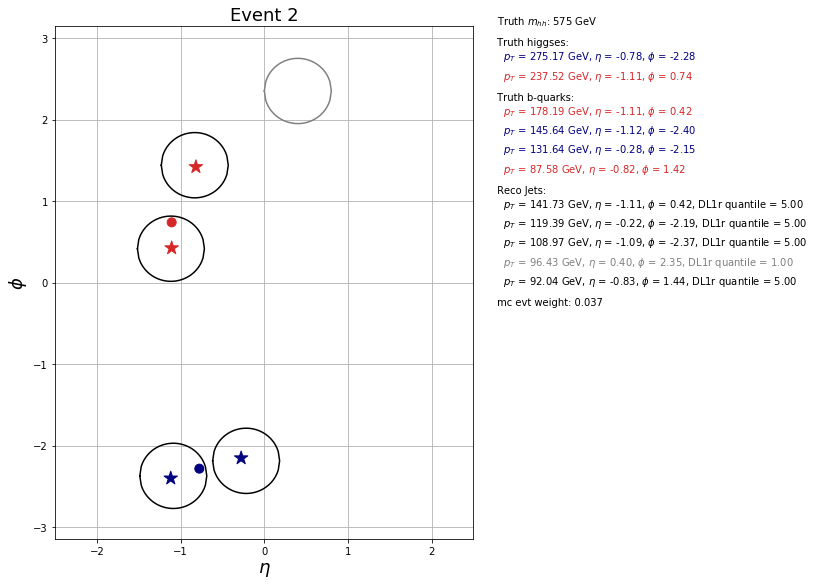

In [324]:
truthDisplay(2,dfi,mode=1,nSelectedJets=nSelectedJets,tagger='DL1r')

Wow - the first thing I noticed when looking @ this is that this event should be *really easy*.

And it was - so I just made this for debugging purposes.

In [326]:
np.sum(dfi.loc[dfi.baselinePair == dfi.correctPair, 'mc_sf']) / np.sum(dfi['mc_sf'])

0.7786004136820546

In [410]:
np.sum(dfi.loc[(dfi.baselinePair == dfi.correctPair) & (dfi.correctPair!=-1), 'mc_sf']) / np.sum(dfi.loc[(dfi.correctPair!=-1),'mc_sf'])

0.8630752973063025

In [411]:
np.sum(dfi.loc[(dfi.baselinePair == dfi.correctPair) & (dfi.correctPair!=-1) & dfi.correctJets, 'mc_sf']) / np.sum(dfi.loc[(dfi.correctPair!=-1) & dfi.correctJets,'mc_sf'])

0.8976197824782486

In [383]:
plt.hist(dfi.loc[dfi.baselinePair != dfi.correctPair,'baselinePair'],16,(-1.5,14.5),histtype='step',density=True,linewidth=1.5)

(array([0.35786243, 0.02990713, 0.09940186, 0.16299386, 0.01448135,
        0.03533764, 0.05957815, 0.0107036 , 0.03911538, 0.03392098,
        0.02180072, 0.02872659, 0.02581458, 0.03045805, 0.02502755,
        0.02487014]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,
         9.5, 10.5, 11.5, 12.5, 13.5, 14.5]),
 <a list of 1 Patch objects>)

In [384]:
plt.hist(dfi.loc[dfi.baselinePair != dfi.correctPair,'correctPair'],16,(-1.5,14.5),histtype='step',density=True,linewidth=1.5)

(array([0.47371321, 0.03093027, 0.0767354 , 0.12458681, 0.0107036 ,
        0.02605068, 0.04549032, 0.00834252, 0.02809696, 0.03455061,
        0.01652762, 0.02164332, 0.02085629, 0.03573115, 0.02526365,
        0.02077759]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,
         9.5, 10.5, 11.5, 12.5, 13.5, 14.5]),
 <a list of 1 Patch objects>)

In [35]:
plt.hist(dfi[[f'pair{i}_Dhh' for i in range(3)]].values,100,(0,100),histtype='step')
plt.show()

**Sanity checking `scoreToIdx` code**

In [157]:
jetToHCIdx

{4: {frozenset({frozenset({0, 1}), frozenset({2, 3})}): 0,
  frozenset({frozenset({0, 2}), frozenset({1, 3})}): 1,
  frozenset({frozenset({1, 2}), frozenset({0, 3})}): 2},
 5: {frozenset({frozenset({0, 1}), frozenset({2, 3})}): 0,
  frozenset({frozenset({0, 2}), frozenset({1, 3})}): 1,
  frozenset({frozenset({1, 2}), frozenset({0, 3})}): 2,
  frozenset({frozenset({0, 1}), frozenset({2, 4})}): 3,
  frozenset({frozenset({0, 2}), frozenset({1, 4})}): 4,
  frozenset({frozenset({1, 2}), frozenset({0, 4})}): 5,
  frozenset({frozenset({3, 4}), frozenset({0, 1})}): 6,
  frozenset({frozenset({1, 4}), frozenset({0, 3})}): 7,
  frozenset({frozenset({1, 3}), frozenset({0, 4})}): 8,
  frozenset({frozenset({3, 4}), frozenset({0, 2})}): 9,
  frozenset({frozenset({2, 4}), frozenset({0, 3})}): 10,
  frozenset({frozenset({2, 3}), frozenset({0, 4})}): 11,
  frozenset({frozenset({3, 4}), frozenset({1, 2})}): 12,
  frozenset({frozenset({2, 4}), frozenset({1, 3})}): 13,
  frozenset({frozenset({1, 4}), froze

In [143]:
from itertools import combinations

In [146]:
scoreToIdx =  {njets:[[[h11,h12], [h21, h22]] for i0,i1,i2,i3 in combinations(range(njets),4) \
                                               for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)])] \
                for njets in range(4,nSelectedJets+1)}

In [147]:
scoreToIdx2

{4: [[[0, 1], [2, 3]], [[0, 2], [1, 3]], [[0, 3], [1, 2]]],
 5: [[[0, 1], [2, 3]],
  [[0, 2], [1, 3]],
  [[0, 3], [1, 2]],
  [[0, 1], [2, 4]],
  [[0, 2], [1, 4]],
  [[0, 4], [1, 2]],
  [[0, 1], [3, 4]],
  [[0, 3], [1, 4]],
  [[0, 4], [1, 3]],
  [[0, 2], [3, 4]],
  [[0, 3], [2, 4]],
  [[0, 4], [2, 3]],
  [[1, 2], [3, 4]],
  [[1, 3], [2, 4]],
  [[1, 4], [2, 3]]]}